In [ ]:
# default_exp learner

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *

from PIL import Image

# Learner

> Basic class for handling the training loop

## Gather the data

In [ ]:
source = untar_data(URLs.MNIST_TINY)
items = get_image_files(source, include=['train', 'valid'])
split_idx = grandparent_splitter()(items)

In [ ]:
class MnistTfm(Transform):
    def __init__(self, items, idx, vocab=None):
        super().__init__()
        self.items = items[idx]
        self.labeller = parent_label
        vals = map(self.labeller, items[idx])
        self.vocab = uniqueify(vals, sort=True) if vocab is None else vocab
        self.o2i = {v:i for i,v in enumerate(self.vocab)}
    
    def __len__(self): return len(self.items)
    
    def encodes(self, i):
        o = self.items[i]
        img = Image.open(o).convert('L')
        return tensor(array(img)).view(1,28,28).float()/255., self.o2i[self.labeller(o)]
    
    def decodes(self, o): return o[0][0],self.vocab[o[1]]
    def show(self, o, ax=None): show_image(o[0], ax, title=o[1], cmap='gray')

In [ ]:
train = MnistTfm(items, split_idx[0])
valid = MnistTfm(items, split_idx[1], vocab=train.vocab)

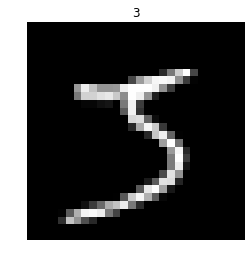

In [ ]:
x,y = train[0]
x.shape,y
train.show(train.decode((x,y)))

In [ ]:
# TODO: take from somewhere else
class Normalize(Transform):
    _order=99
    def __init__(self, mean, std, do_x=True, do_y=False):
        self.mean,self.std,self.do_x,self.do_y = mean,std,do_x,do_y
        
    def encodes(self, b):
        x,y = b
        if self.do_x: x = self.normalize(x)
        if self.do_y: y = self.normalize(y)
        return x,y
    
    def decodes(self, b):
        x,y = b
        if self.do_x: x = self.denorm(x)
        if self.do_y: y = self.denorm(y)
        return x,y
    
    def normalize(self, x): return (x - self.mean) / self.std
    def denorm(self, x):    return x * self.std + self.mean

In [ ]:
train_dl,valid_dl = map(lambda o: DataLoader(o[1], batch_size=256, shuffle=(o[0]==0)), enumerate([train,valid]))
train_dl,valid_dl = map(lambda dl: TfmDataLoader(dl, tfms), [train_dl,valid_dl])